In [21]:
print(1+2)

3


In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import qiskit
print(qiskit.__version__)

2.2.3


In [24]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)

0.43.1


In [25]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram



<br>

**Quantum Fourier Transform**

---

Circuit Diagram:


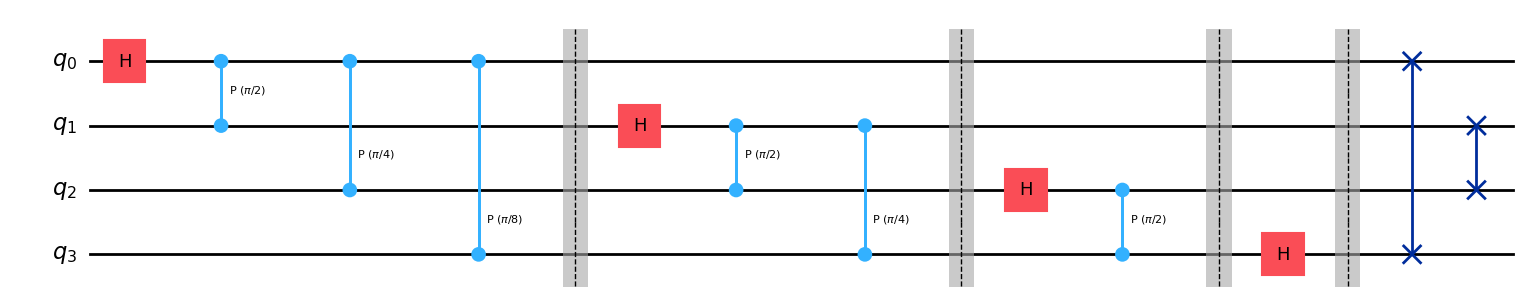

In [26]:

# 1. Define the QFT Function
def make_qft_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Add Rotations
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
        qc.barrier()
            
    # Add Swaps to reverse qubit order
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - i - 1)
        
    return qc

n = 4
qft_circuit = make_qft_circuit(n)
print("Circuit Diagram:")
qft_circuit.draw("mpl")


<br>

**QFT gate**

---

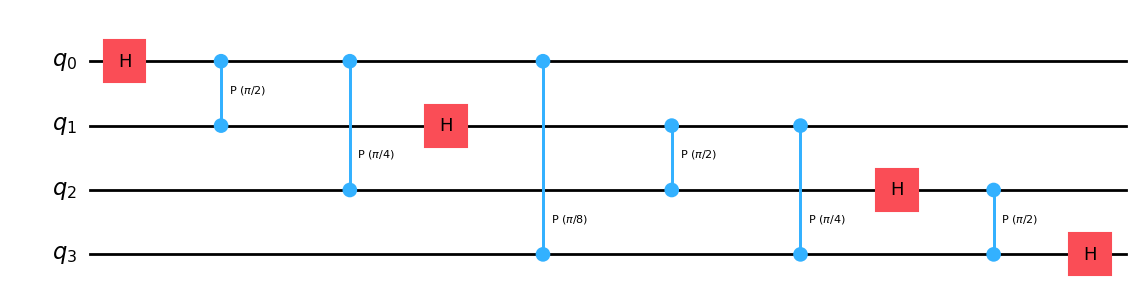

In [27]:

def make_QFT(n_qubits, do_swaps=True):
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
            
    if do_swaps:
        for i in range(n_qubits // 2):
            qc.swap(i, n_qubits - i - 1)
    
    qft_qc = qc.to_gate()
    qft_qc.name="QFT"
    return qft_qc

n = 4
qft_gate = make_QFT(n, do_swaps=False)
qft_gate.definition.draw("mpl")


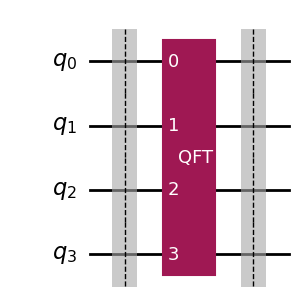

In [28]:

qc = QuantumCircuit(n)

qc.barrier()
qc.append(qft_gate, range(n))
qc.barrier()

qc.draw("mpl")
# qc.decompose().draw("mpl")


<br>

**IQFT gate**

---

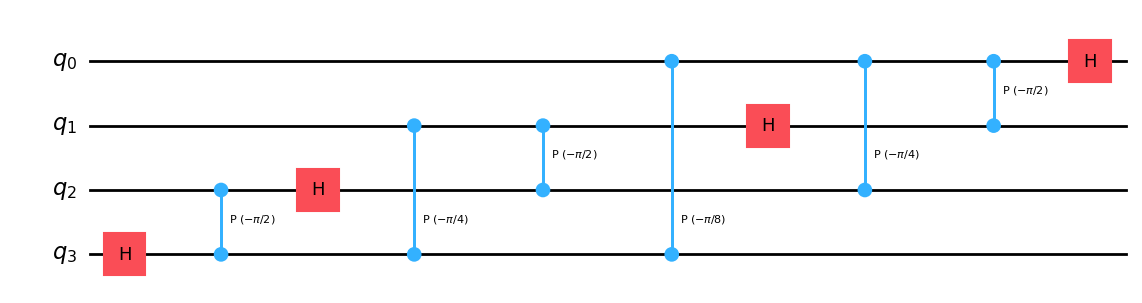

In [29]:
iqft_gate = qft_gate.inverse()
iqft_gate.name="IQFT"
iqft_gate.definition.draw("mpl")

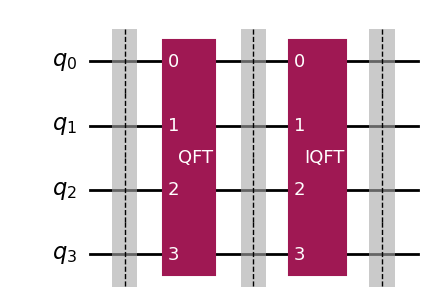

In [30]:
qc.append(iqft_gate, range(n))
qc.barrier()
qc.draw("mpl")


<br>

**visualizing a number on qft and applying IQFT to recover number**

---

In [31]:
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator


num = 30
print(f"binary of {num} = {bin(num)}")

n_qubits = num.bit_length()
print("qubits needed =", n_qubits)

bitstring = format(num, f"0{n_qubits}b")[::-1]
print(f"bit-string : {bitstring}")


binary of 30 = 0b11110
qubits needed = 5
bit-string : 01111


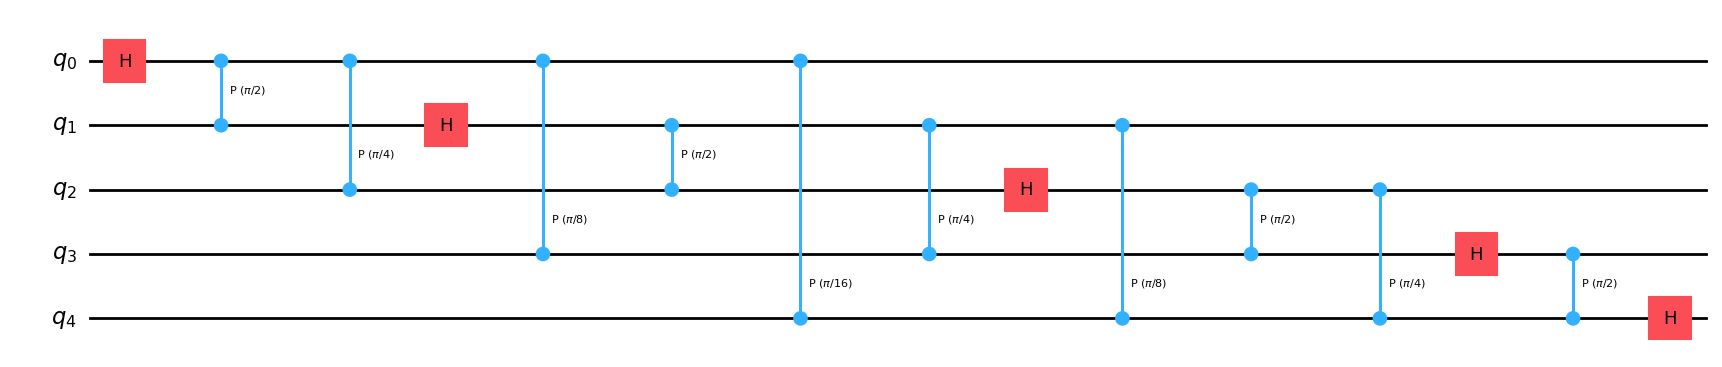

In [32]:

def make_QFT(n_qubits, do_swaps=True):
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
            
    if do_swaps:
        for i in range(n_qubits // 2):
            qc.swap(i, n_qubits - i - 1)
    
    qft_qc = qc.to_gate()
    qft_qc.name="QFT"
    return qft_qc

qft_gate = make_QFT(n_qubits, do_swaps=False)
qft_gate.definition.draw("mpl")


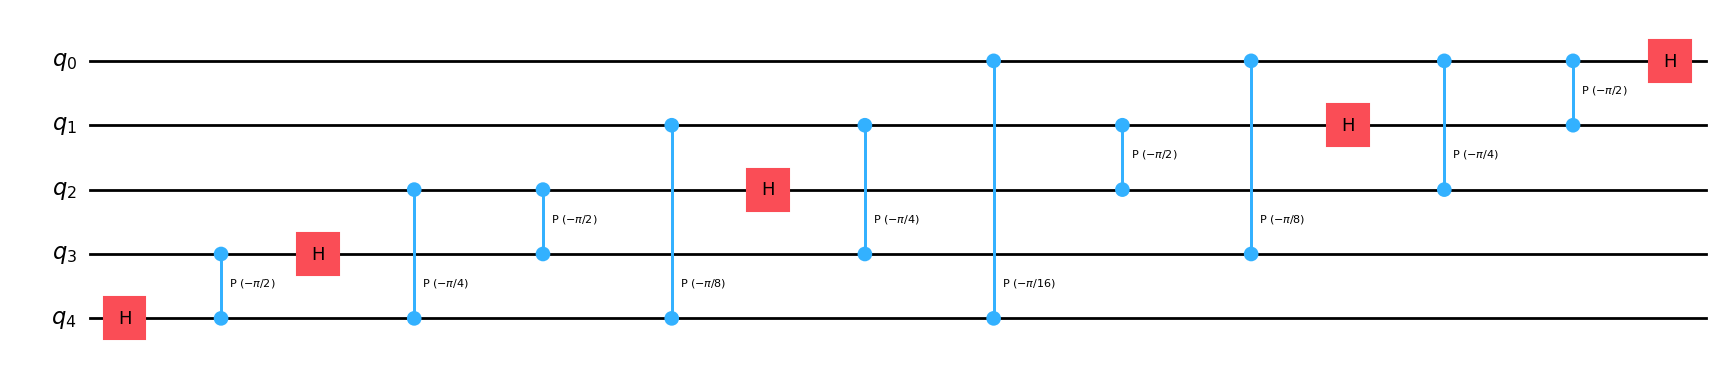

In [33]:

iqft_gate = qft_gate.inverse()
iqft_gate.name="IQFT"
iqft_gate.definition.draw("mpl")

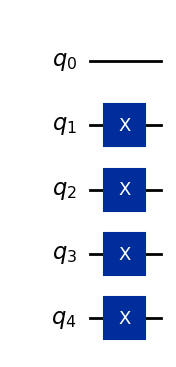

In [34]:
qc = QuantumCircuit(n_qubits)
for idx, bit in enumerate(bitstring):
    if bit == '1':
        qc.x(idx)
qc.draw("mpl")

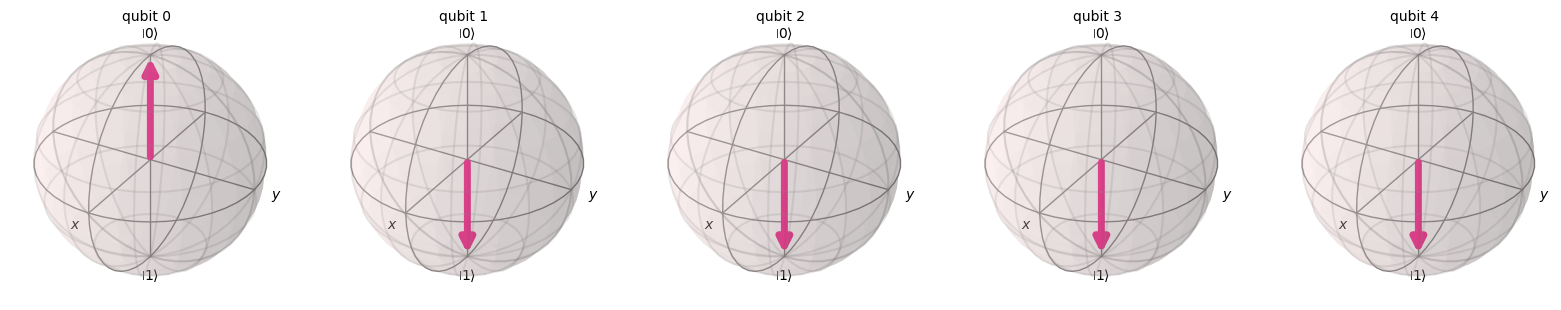

In [35]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

plot_bloch_multivector(qc)

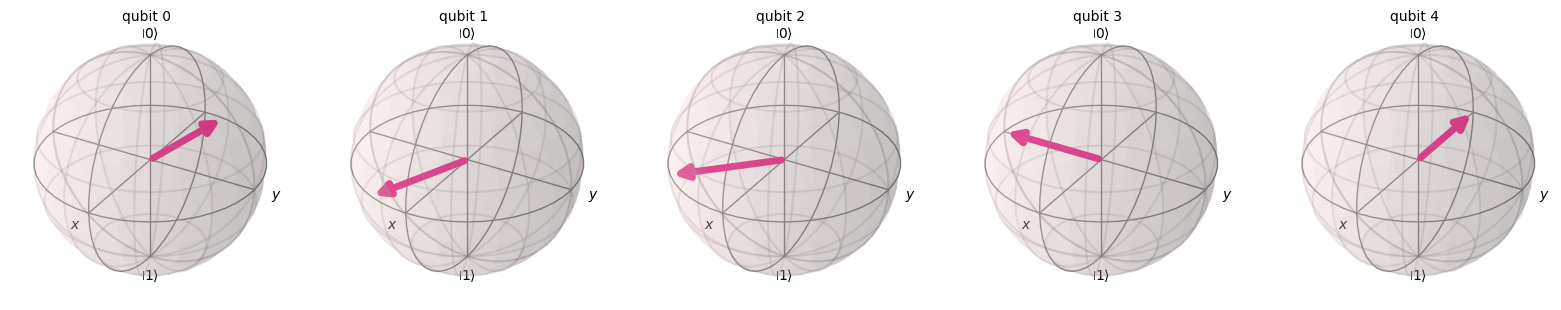

In [36]:
qc.barrier()
qc.append(qft_gate, range(n_qubits))

plot_bloch_multivector(qc)

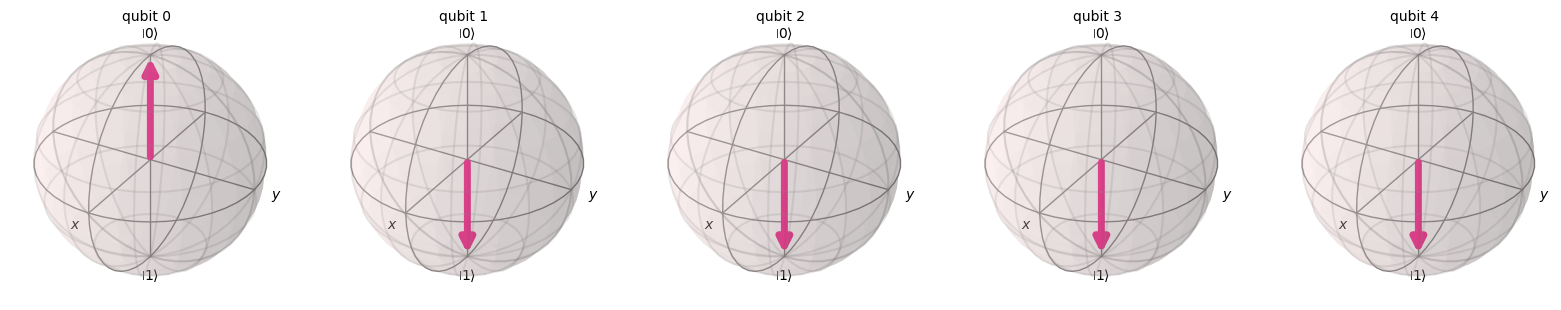

In [37]:
qc.barrier()
qc.append(iqft_gate, range(n_qubits))
plot_bloch_multivector(qc)

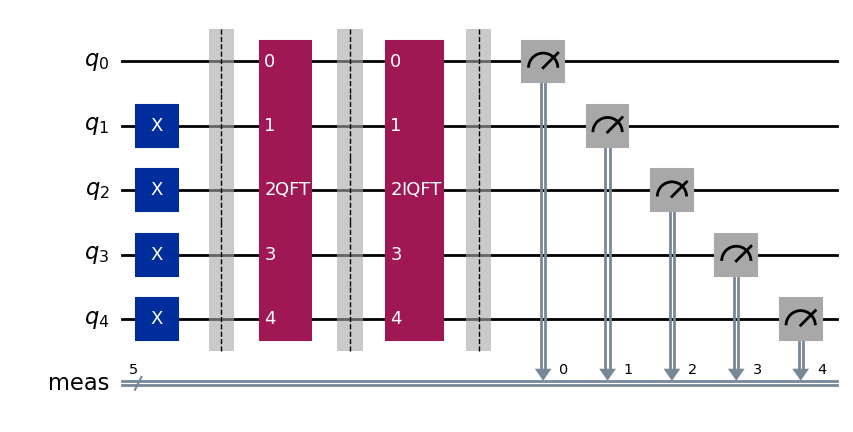

In [38]:
qc.measure_all()
qc.draw("mpl")

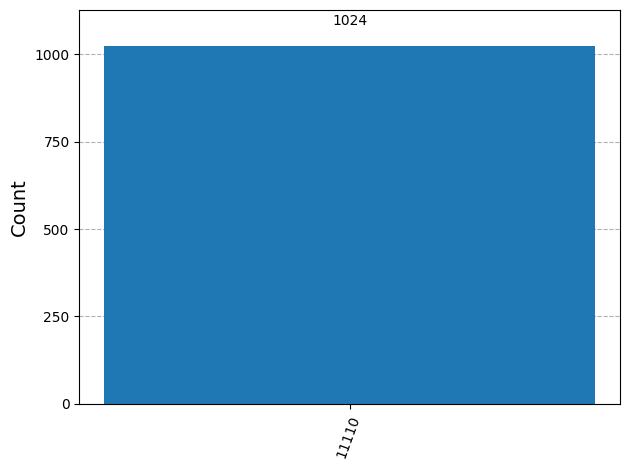

In [39]:
from qiskit.visualization import plot_histogram

simulator = AerSimulator()

compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)

result = job.result()
counts = result.get_counts()

plot_histogram(counts)

In [41]:
# ------------------------------
# 1. BUILD CUSTOM NOISE MODEL
# ------------------------------


from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, thermal_relaxation_error

noise_model = NoiseModel()

depol_1q = 0.005      # 0.5% 1-qubit depolarizing noise
depol_2q = 0.02       # 2%   2-qubit depolarizing noise
t1 = 50e3             # T1 = 50 microseconds
t2 = 70e3             # T2 = 70 microseconds
gate_time_1q = 100    # 100 ns
gate_time_2q = 300    # 300 ns

# Add 1-qubit depolarizing noise
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(depol_1q, 1),
    ['x', 'h', 'z']
)

# Add 2-qubit noise
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(depol_2q, 2),
    ['cx']
)

# Add relaxation noise (thermal relaxation)
therm_relax_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
therm_relax_2q = thermal_relaxation_error(t1, t2, gate_time_2q).tensor(
    thermal_relaxation_error(t1, t2, gate_time_2q)
)

noise_model.add_all_qubit_quantum_error(therm_relax_1q, ['x', 'h', 'z'])
noise_model.add_all_qubit_quantum_error(therm_relax_2q, ['cx'])



counts: {'00100': 6, '00000': 5, '01011': 14, '00011': 7, '10001': 49, '00010': 9, '11010': 93, '00001': 31, '01000': 10, '11000': 30, '00101': 16, '10101': 41, '01100': 26, '11111': 100, '11101': 72, '00110': 36, '10110': 117, '01111': 30, '01110': 133, '10011': 17, '10111': 33, '01101': 30, '10000': 8, '11001': 71, '10010': 16, '10100': 33, '00111': 8, '11110': 806, '01010': 21, '11100': 85, '01001': 45, '11011': 50}


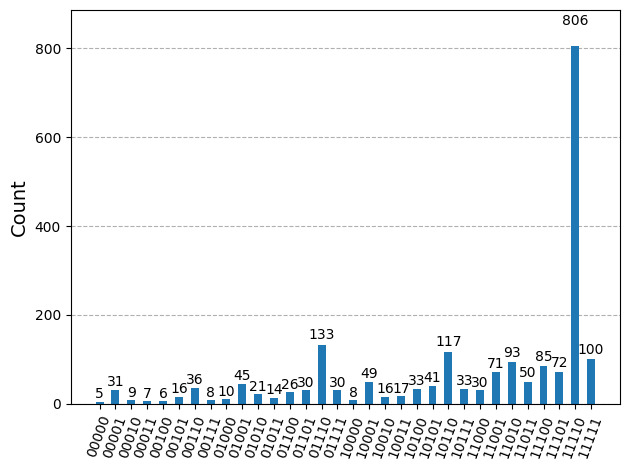

In [44]:


sim_noise = AerSimulator(noise_model=noise_model)

compiled = transpile(qc, sim_noise)
job = sim_noise.run(compiled, shots=2048)
result = job.result()
counts = result.get_counts()
print("\ncounts:", counts)

plot_histogram(counts)
